# DNN-DMP Model

### The network architecture of the DNN-DMP model

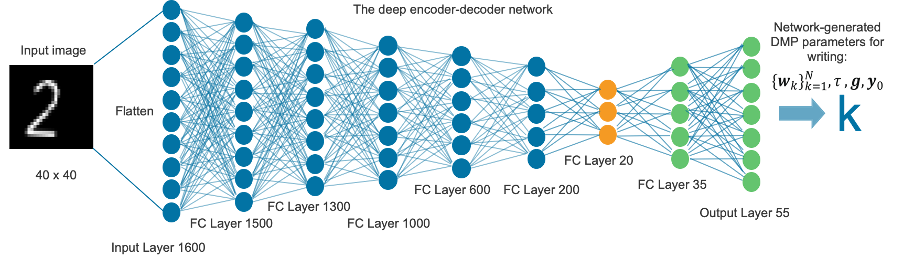

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import numpy as np
import cv2
import torch
import re
import importlib
plt.ion() 

## Load Models  training on s-MNIST  datasets

Helper function for loading saved models:

In [2]:
def load_model(root_path, model_path):
    # Read network description file
    with open(os.path.join(root_path, model_path, 'network_description.txt')) as f:
        network_description_str = f.read()

    # Get the model class from the network description and dynamically import it
    model_module_class_str = re.search('Model: (.+?)\n', network_description_str).group(1)
    model_module_str = os.path.splitext(model_module_class_str)[0]
    model_class_str = os.path.splitext(model_module_class_str)[1][1:]
    model_module = importlib.import_module(model_module_str)
    model_class = getattr(model_module, model_class_str)

    # Get the pre-trained CNN model load path from the network description
    if model_class_str == 'CNNEncoderDecoderNet':
        pre_trained_cnn_model_path = os.path.join(root_path, re.search('Pre-trained CNN model load path: (.+?)\n', network_description_str).group(1))

    # Load layer sizes
    layer_sizes = np.load(os.path.join(model_path, 'layer_sizes.npy'), allow_pickle=True).tolist()

    # Load scaling
    try:
        scaling = Mapping()
        scaling.x_max = np.load(os.path.join(root_path, model_path, 'scale_x_max.npy'))
        scaling.x_min = np.load(os.path.join(root_path, model_path, 'scale_x_min.npy'))
        scaling.y_max = np.load(os.path.join(root_path, model_path, 'scale_y_max.npy'))
        scaling.y_min = np.load(os.path.join(root_path, model_path, 'scale_y_min.npy'))
    except:
        scaling = np.load(os.path.join(root_path, model_path, 'scale.npy'))

    # Load the model
    if model_class_str == 'CNNEncoderDecoderNet':
        model = model_class(pre_trained_cnn_model_path, layer_sizes, scaling)
    else:
        model = model_class(layer_sizes, None, scaling)
        
    # Load the model state parameters
    state = torch.load(os.path.join(root_path, model_path, 'net_parameters'), map_location=torch.device('cpu'))
    model.load_state_dict(state)
    
    return model

### Show Images

In [3]:
def show_images(image, trajectory, dmp):
    C = None
    H, W = image.shape
    
    fig = plt.figure()
    fig.tight_layout()

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    
    dmp.joint()
    plt.subplot(1, 2, 2)
    plt.plot(dmp.Y[:,0], dmp.Y[:,1],'-r', linewidth=3.0)
        
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0]) 

    plt.subplot(1, 2, 1)
    plt.plot(trajectory[:,0], trajectory[:,1],'-b', linewidth=3.0)

       
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0]) 
    
    plt.subplot(1, 2, 2)
    plt.plot(trajectory[:,0], trajectory[:,1],'-b', linewidth=3.0)

    dmp.joint()
    plt.subplot(1, 2, 2)
    plt.plot(dmp.Y[:,0], dmp.Y[:,1],'-r', linewidth=3.0)    

In [4]:
def show_figures(image_dir, data_stub, digit, inputs, outputs, model, test_sample_indices):
    torch_images = torch.autograd.Variable(torch.from_numpy(inputs[test_sample_indices, :])).float()
    torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()

    torch_predicted_outputs = model(torch_images)

    for i_sample in range(torch_predicted_outputs.shape[0]):
        sample_output_dmp = trainer.create_dmp(torch_outputs[i_sample,:], model.scale, 0.01, 25, True)
        torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[i_sample,:]), 0)
        sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.01, 25, True)
        sample_output_dmp.joint()
        fig, _ = trainer.show_dmp(torch_images[i_sample,:], sample_output_dmp.Y, sample_predicted_output_dmp, plot=True)
        image_name = data_stub+'_'+str(digit)+'_'+str(i_sample)+'.png'
        fig.savefig(image_dir+'/'+image_name)

In [5]:
def demo():
    test_sample_indices = [1882, 2102, 2142, 2382, 2732]
    torch_images = torch.autograd.Variable(torch.from_numpy(images[test_sample_indices, :])).float()
    torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()

    torch_predicted_outputs = model(torch_images)

    sample_output_dmp = trainer.create_dmp(torch_outputs[0,:], model.scale, 0.001, 25, True)
    sample_output_dmp.joint()
    torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[0,:]), 0)
    sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.001, 25, True)

    show_images(torch_images[0,:], sample_output_dmp.Y, sample_predicted_output_dmp)

### Testing examples

In [6]:
digit_str = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'all']
test_samples = [[490, 740, 1100, 1330, 1800, 2700],
                [461, 521, 901, 1001, 1101, 1431, 2061, 2141],
                [322, 422, 1532, 1762, 1882, 2102, 2142, 2382, 2732],
                [333, 1023, 1623, 2823, 2963],
                [214, 284, 894, 954, 1244, 1254, 1754, 1954],
                [295, 1715, 1795, 2075, 2265],
                [146, 166, 456, 546, 746, 1016, 1276, 1956, 1976, 2646],
                [157, 487, 547, 577, 737, 727, 977, 1147, 2327, 1577, 1687],
                [988, 1418, 1678, 1818, 2578, 2648],
                [1629, 1969, 1999, 2019],
                [490, 901, 2732, 1623, 214, 1715, 1976, 977, 988, 1629]
               ]

In [7]:
root_path = os.path.dirname(os.getcwd()) + '/imednet'
sys.path.append(root_path)
print("root path:", root_path)

root path: /Users/shengdaolin_sh/dir_developer/workspaces/pycharm/acs-project-msc_project_ndp/imednet


### 1, DNN-DMP Trained on s-mnist

In [8]:
from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer

model_path = os.path.join(root_path, 'models/encoder_decoder/imednet-40x40-smnist 2021-07-29 22:01:38.504222/')
model = load_model(root_path, model_path)
model_stub = 'imednet_etoe'
print(model)

No cuda library
EncoderDecoderNet(
  (input_layer): Linear(in_features=1600, out_features=1500, bias=True)
  (middle_layer_1): Linear(in_features=1500, out_features=1300, bias=True)
  (middle_layer_2): Linear(in_features=1300, out_features=1000, bias=True)
  (middle_layer_3): Linear(in_features=1000, out_features=600, bias=True)
  (middle_layer_4): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_5): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_6): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


In [9]:
# Synthectic MNIST (s-MNIST)
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist.mat')
data_stub = 'smnist'
# Load data and scale it
images, outputs, scale, or_tr = MatLoader.load_data(data_path, load_original_trajectories=True)
trainer = Trainer()

In [10]:
or_trajectories = torch.Tensor(np.array(or_tr)[:, :, :]).float()
or_trajectories.shape

torch.Size([20000, 301, 3])

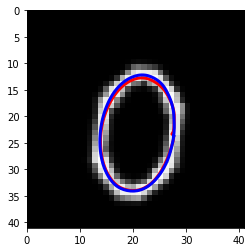

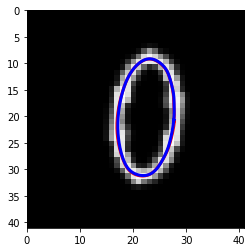

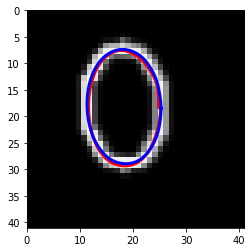

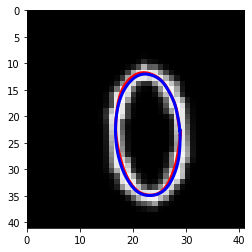

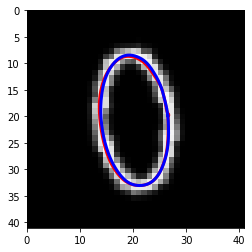

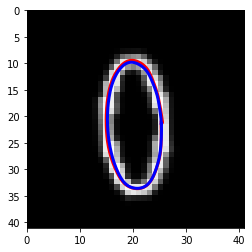

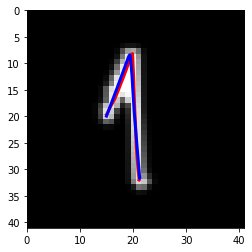

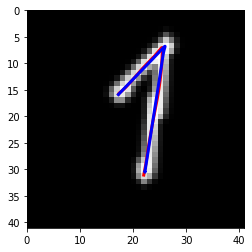

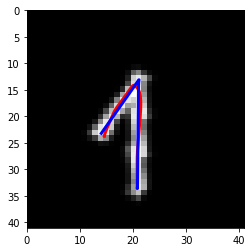

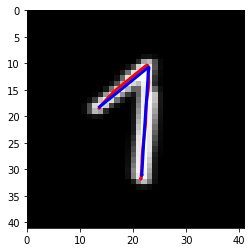

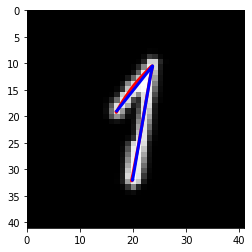

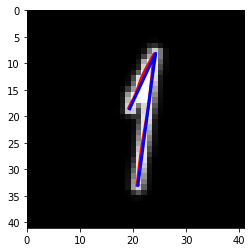

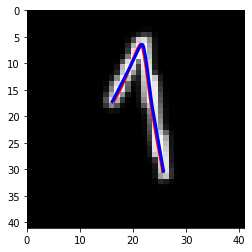

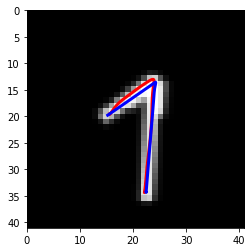

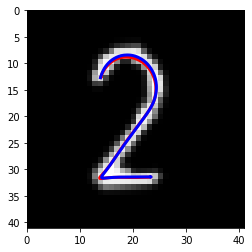

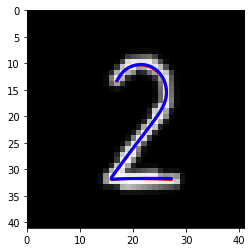

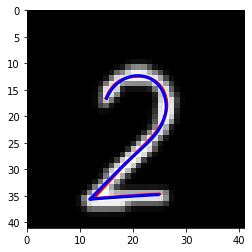

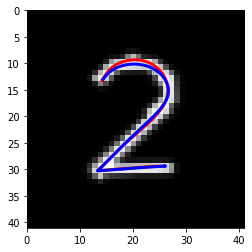

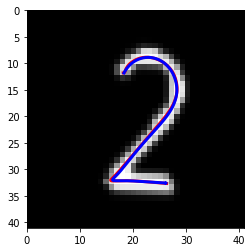

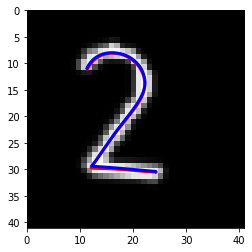

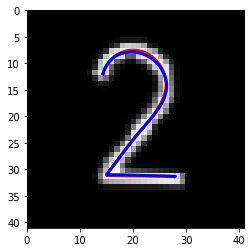

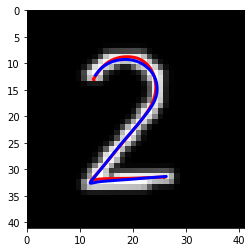

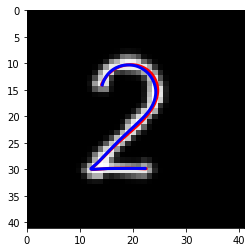

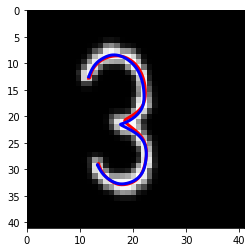

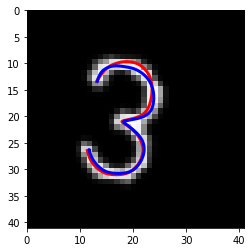

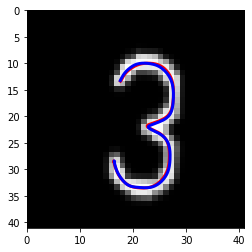

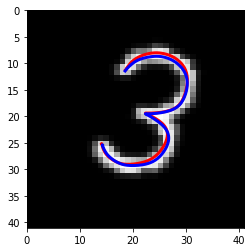

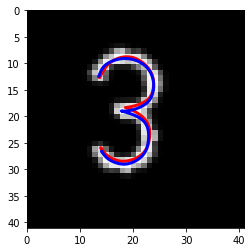

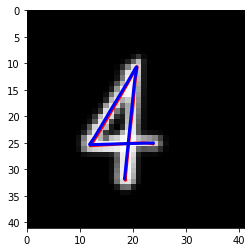

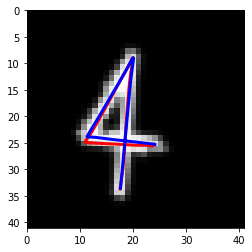

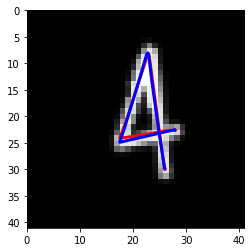

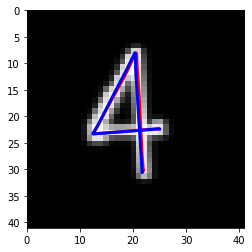

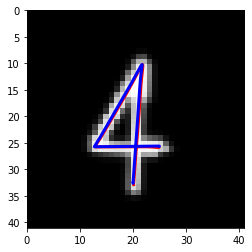

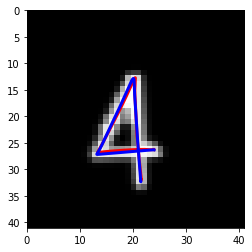

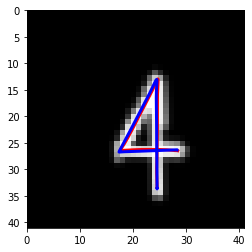

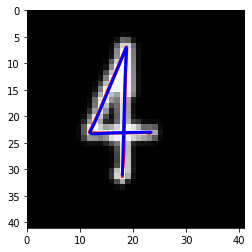

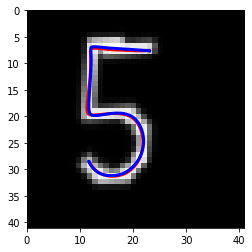

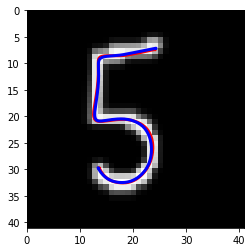

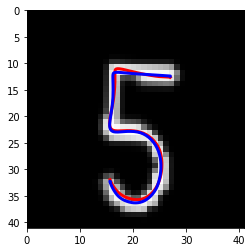

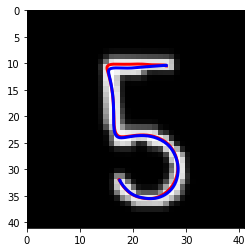

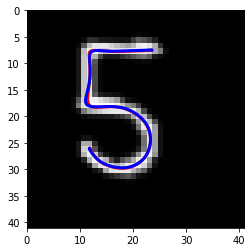

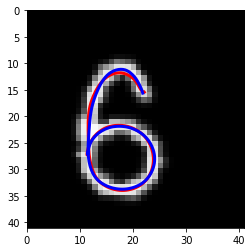

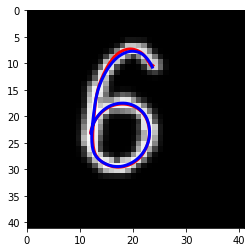

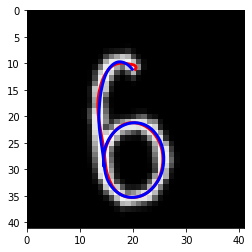

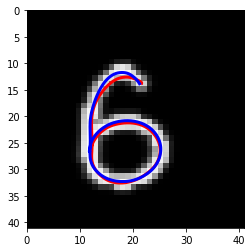

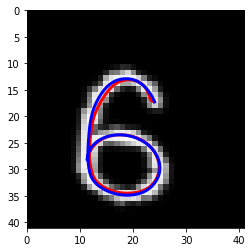

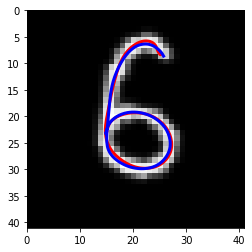

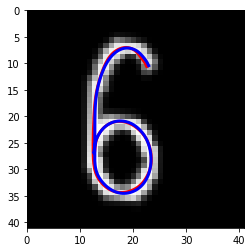

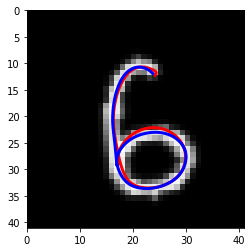

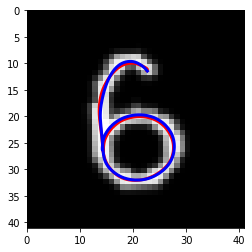

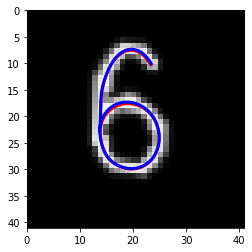

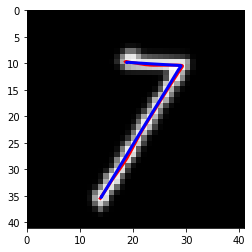

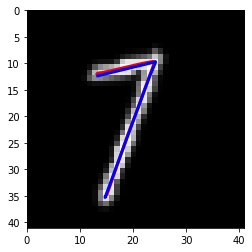

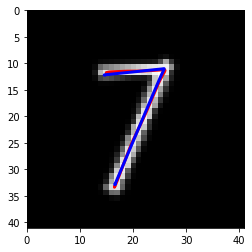

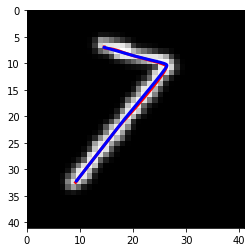

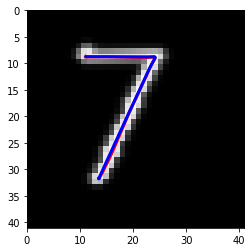

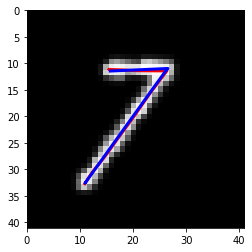

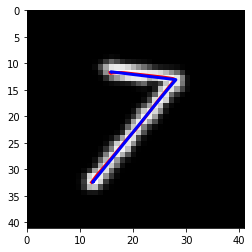

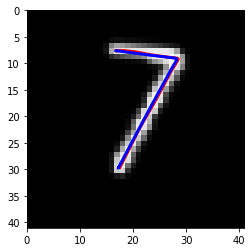

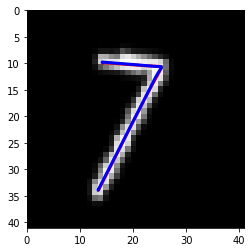

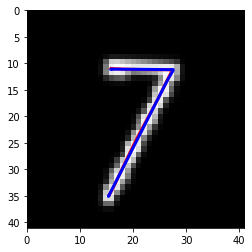

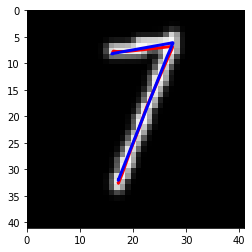

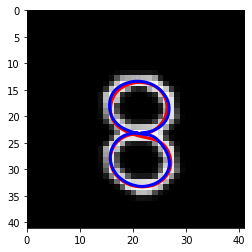

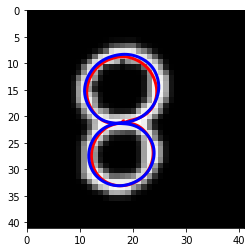

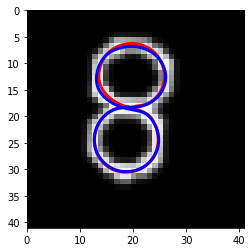

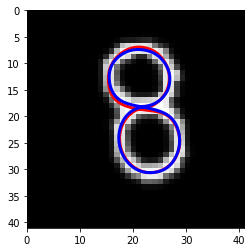

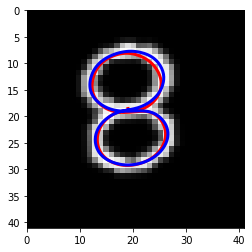

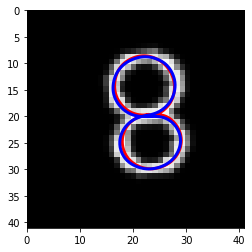

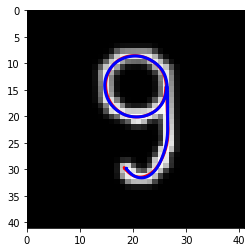

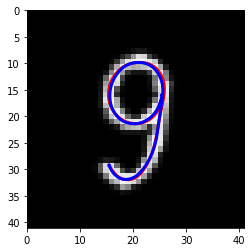

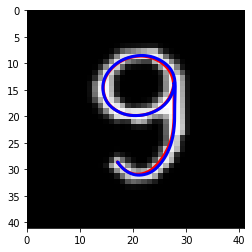

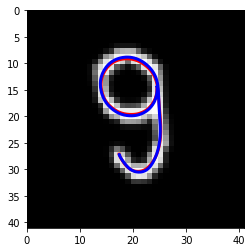

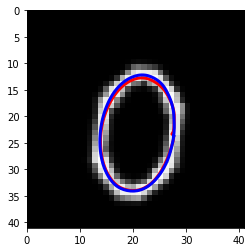

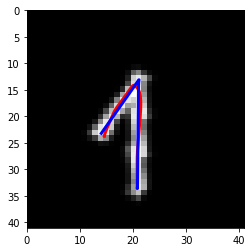

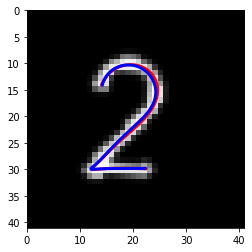

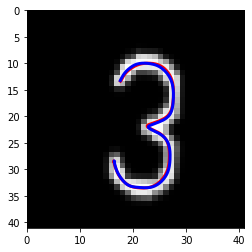

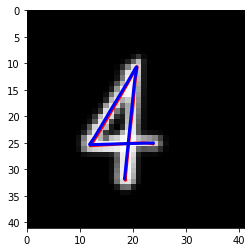

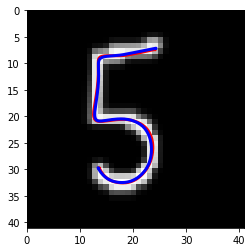

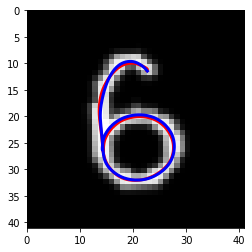

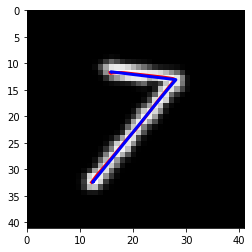

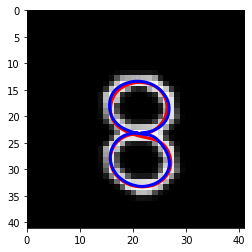

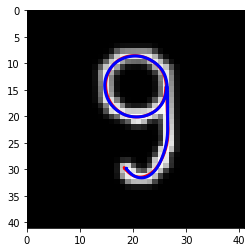

In [11]:
# Examples of Digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# loop for show the images
for i in range(0, len(digit_str)):
    digit = digit_str[i]
    test_sample_indices = test_samples[i]
    show_figures('./images/dnn-dmp/smnist', data_stub, digit,images, outputs, model, test_sample_indices)

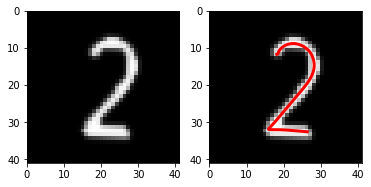

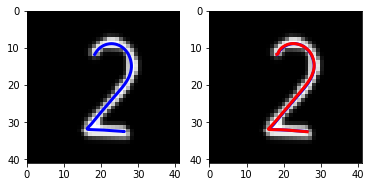

In [12]:
demo()

### 2, DNN-DMP Trained on s-MNIST-AWGN

In [13]:
from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer

model_path = os.path.join(root_path, 'models/encoder_decoder/imednet-40x40-smnist-with-awgn 2021-07-29 22:02:07.718483/')
model = load_model(root_path, model_path)
model_stub = 'imednet_etoe_awgn'
print(model)

EncoderDecoderNet(
  (input_layer): Linear(in_features=1600, out_features=1500, bias=True)
  (middle_layer_1): Linear(in_features=1500, out_features=1300, bias=True)
  (middle_layer_2): Linear(in_features=1300, out_features=1000, bias=True)
  (middle_layer_3): Linear(in_features=1000, out_features=600, bias=True)
  (middle_layer_4): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_5): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_6): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


In [14]:
# Synthetic MNIST with Additive White Gaussian Noise with 9.5 Signal-to-Noise Ratio (s-MNIST-AWGN-9.5-SNR)
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-awgn.mat')
data_stub = 'smnist-awgn'

# Load data and scale it
images, outputs, scale, or_tr = MatLoader.load_data(data_path, load_original_trajectories=True)
trainer = Trainer()

In [15]:
or_trajectories = torch.Tensor(np.array(or_tr)[:, :, :]).float()
or_trajectories.shape

torch.Size([20000, 301, 3])

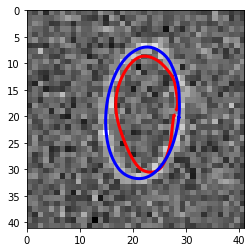

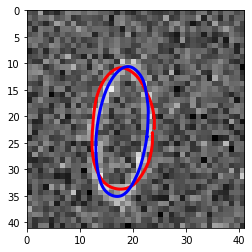

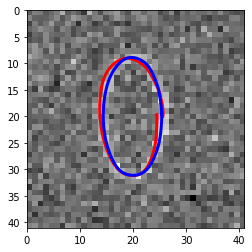

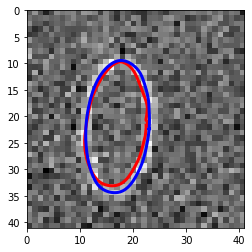

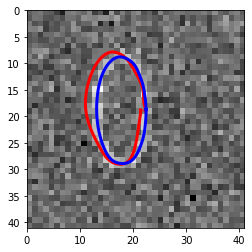

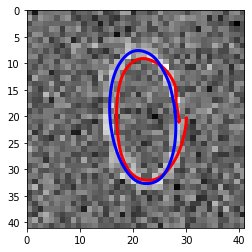

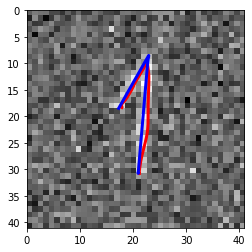

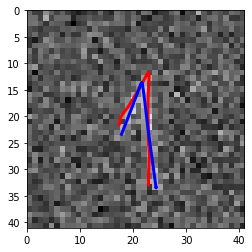

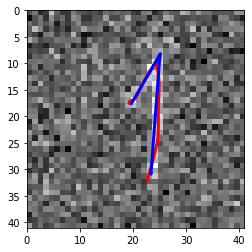

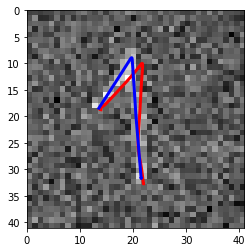

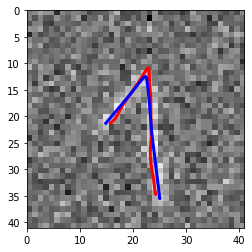

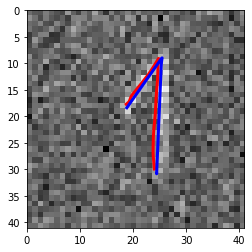

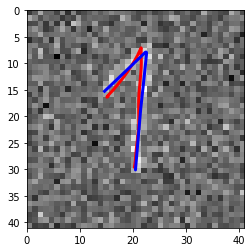

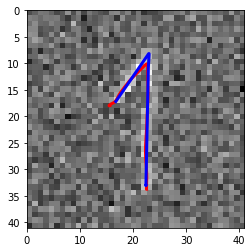

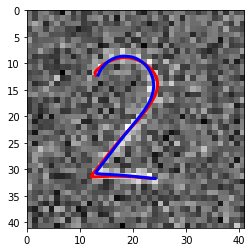

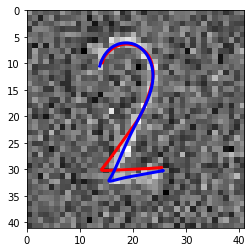

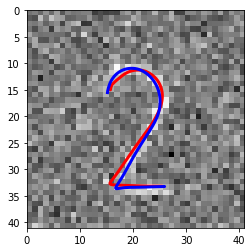

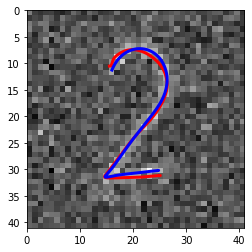

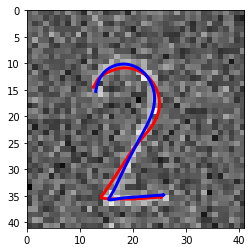

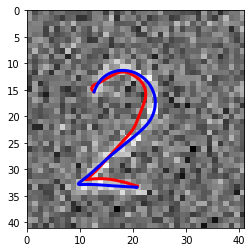

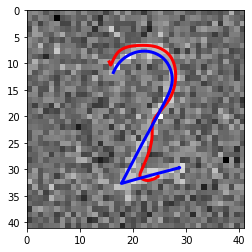

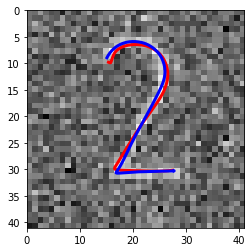

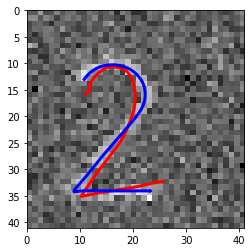

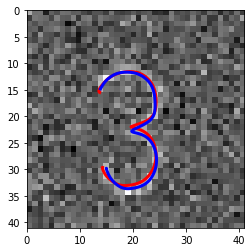

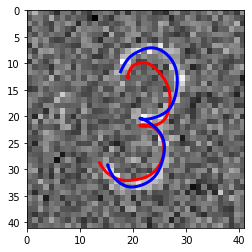

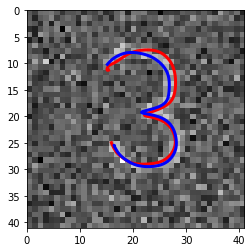

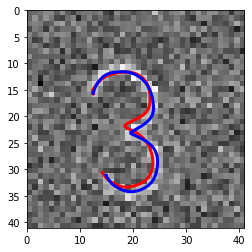

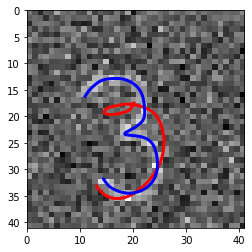

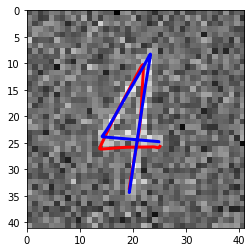

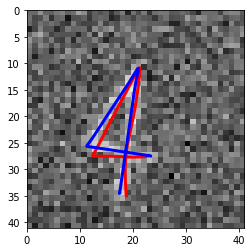

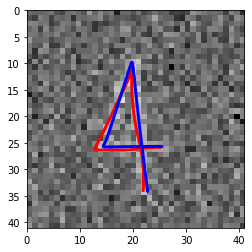

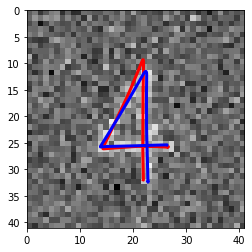

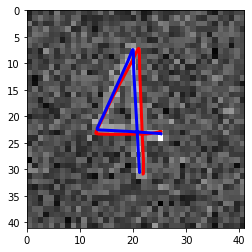

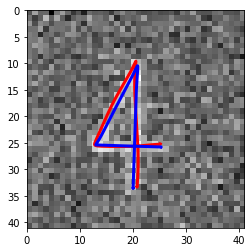

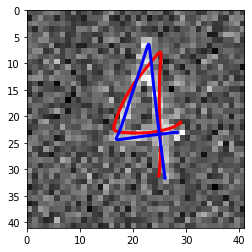

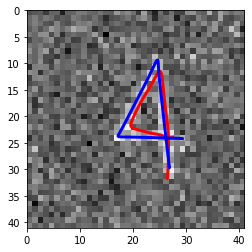

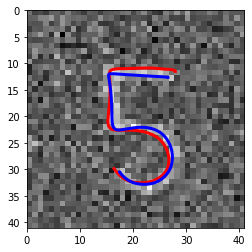

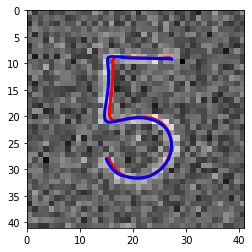

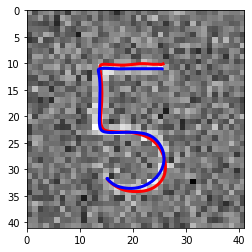

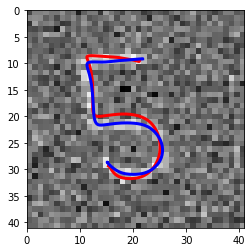

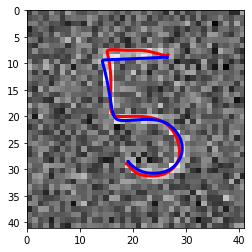

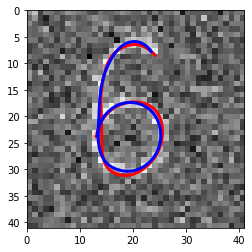

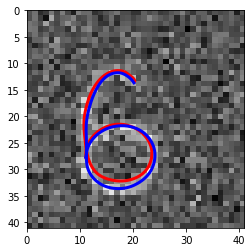

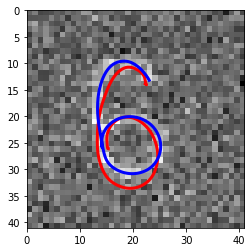

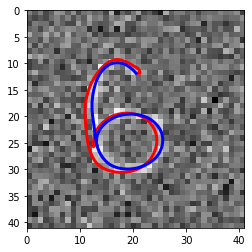

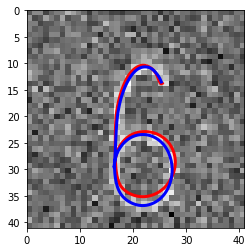

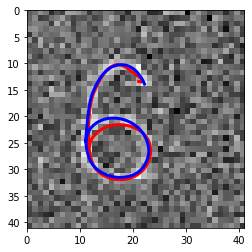

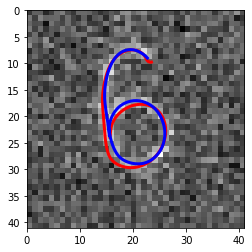

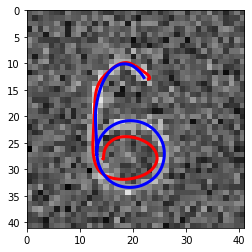

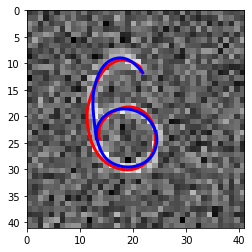

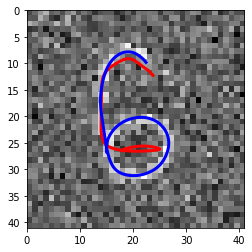

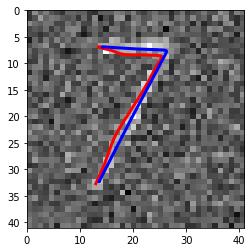

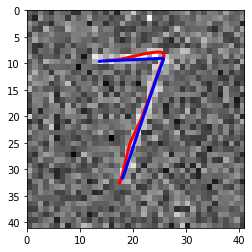

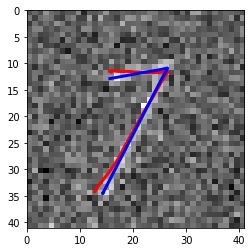

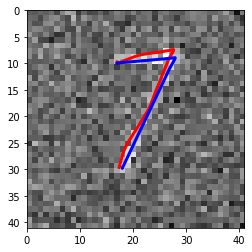

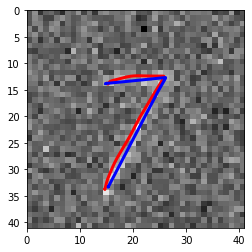

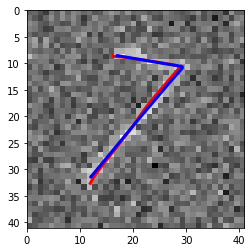

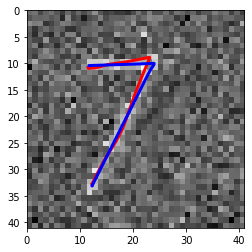

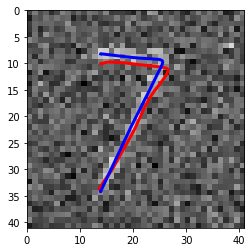

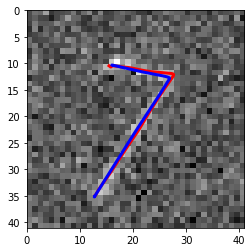

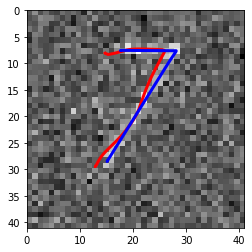

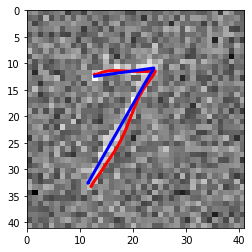

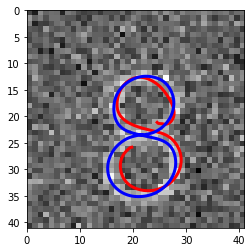

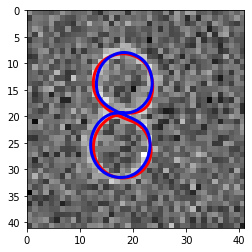

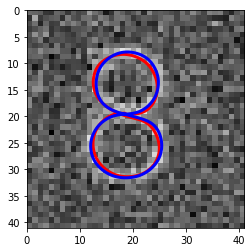

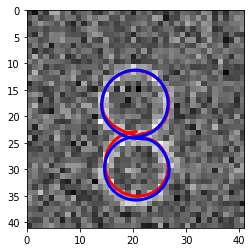

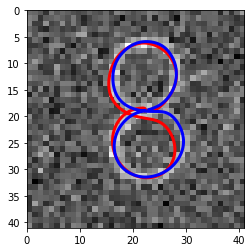

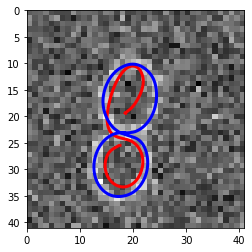

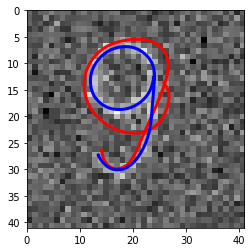

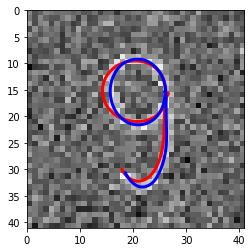

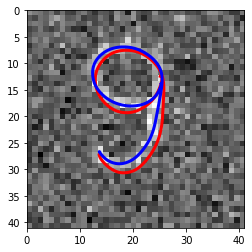

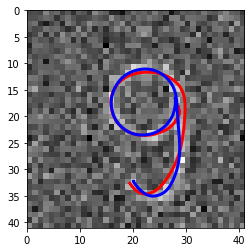

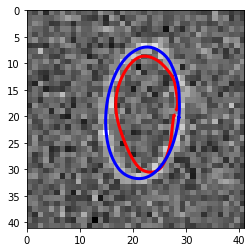

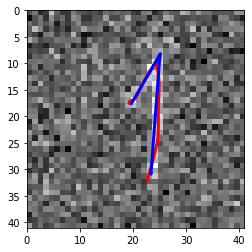

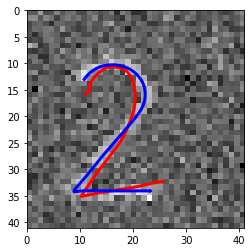

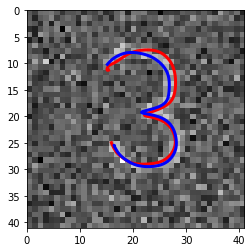

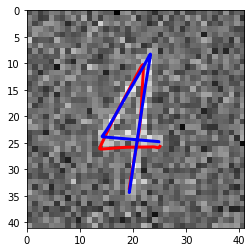

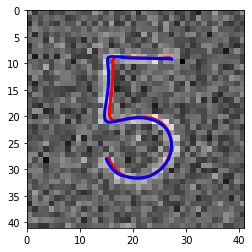

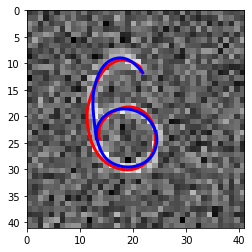

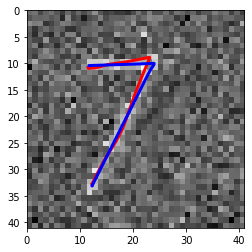

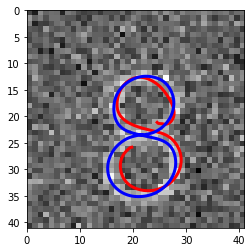

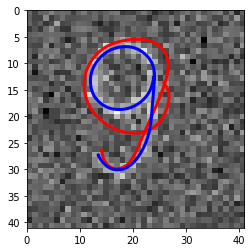

In [16]:
# Examples of Digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# loop for show the images
for i in range(0, len(digit_str)):
    digit = digit_str[i]
    test_sample_indices = test_samples[i]
    show_figures('./images/dnn-dmp/smnist-awgn', data_stub, digit,images, outputs, model, test_sample_indices)

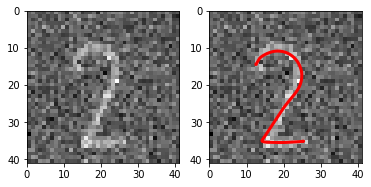

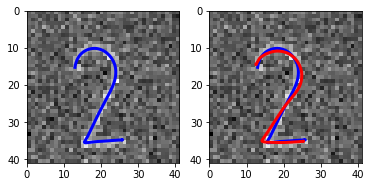

In [17]:
demo()

### 3, DNN-DMP Trained on s-MNIST-MB

In [18]:
from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer

model_path = os.path.join(root_path, 'models/encoder_decoder/imednet-40x40-smnist-with-motion-blur 2021-07-29 22:15:54.192095/')
model = load_model(root_path, model_path)
model_stub = 'imednet_etoe_mb'
print(model)

EncoderDecoderNet(
  (input_layer): Linear(in_features=1600, out_features=1500, bias=True)
  (middle_layer_1): Linear(in_features=1500, out_features=1300, bias=True)
  (middle_layer_2): Linear(in_features=1300, out_features=1000, bias=True)
  (middle_layer_3): Linear(in_features=1000, out_features=600, bias=True)
  (middle_layer_4): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_5): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_6): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


In [19]:
# Synthetic MNIST with Motion Blur (s-MNIST-MB)
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-motion-blur.mat')
data_stub = 'smnist-mb'

# Load data and scale it
images, outputs, scale, or_tr = MatLoader.load_data(data_path, load_original_trajectories=True)
trainer = Trainer()

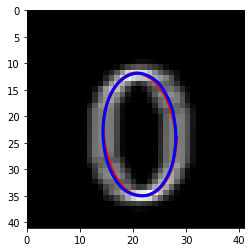

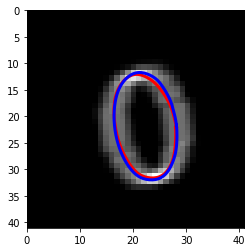

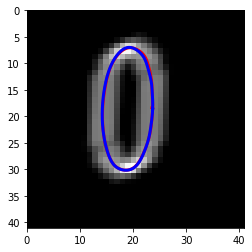

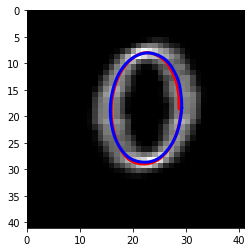

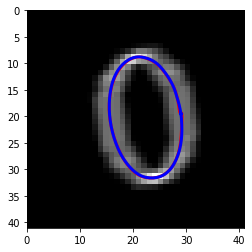

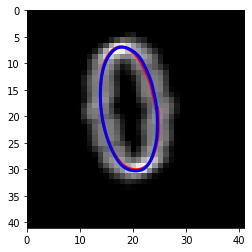

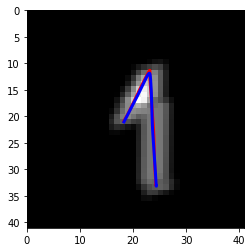

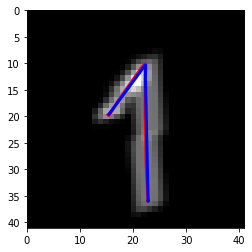

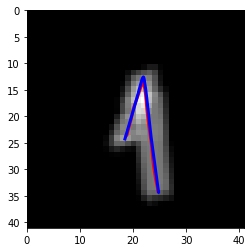

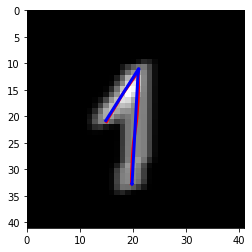

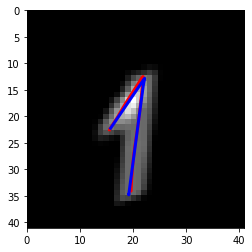

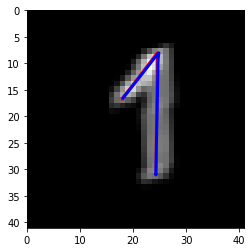

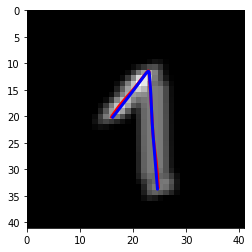

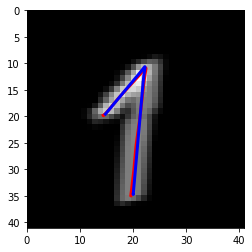

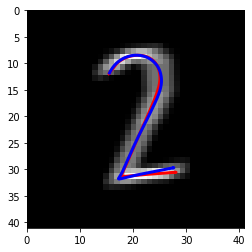

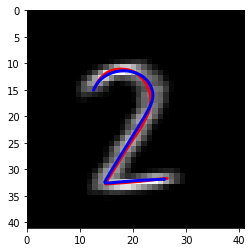

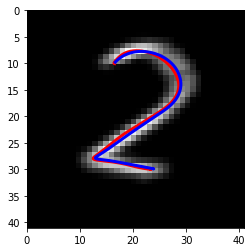

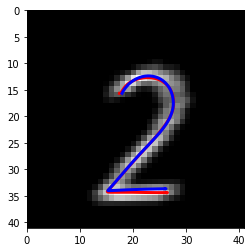

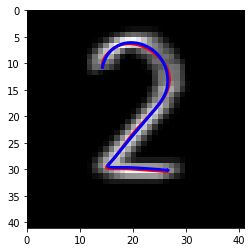

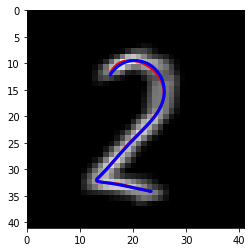

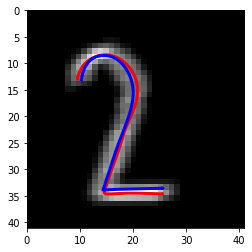

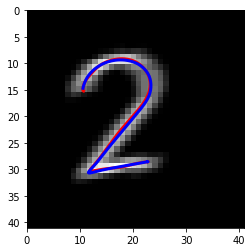

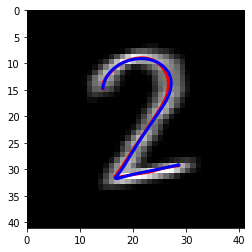

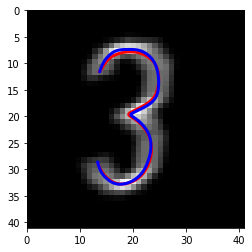

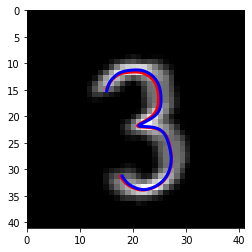

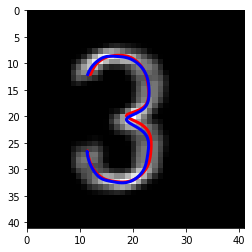

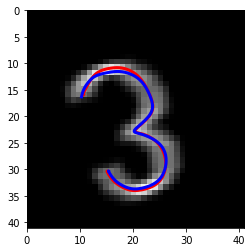

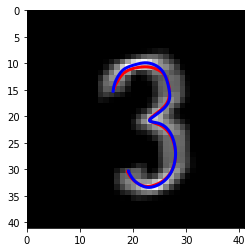

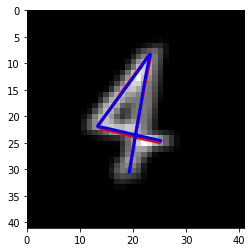

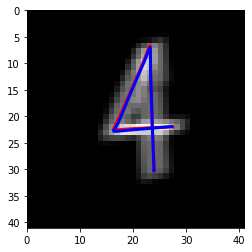

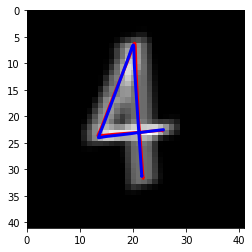

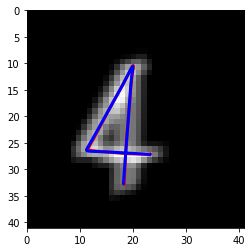

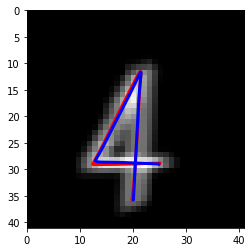

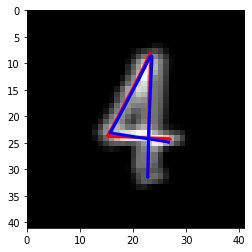

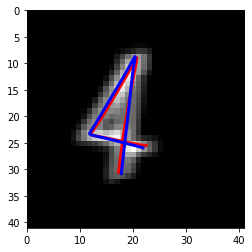

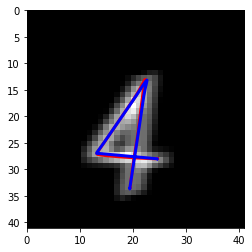

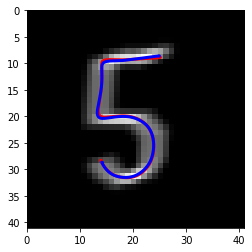

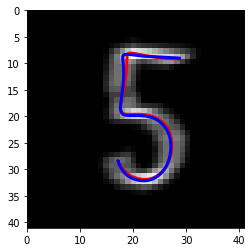

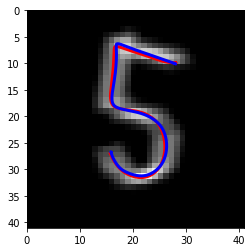

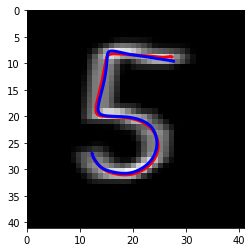

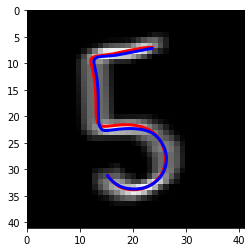

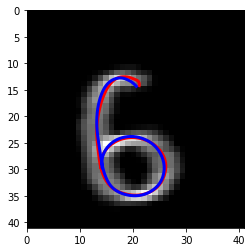

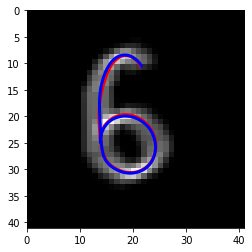

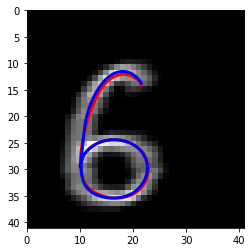

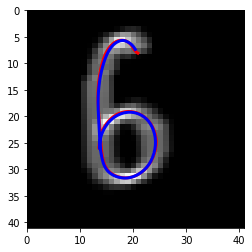

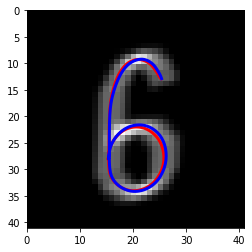

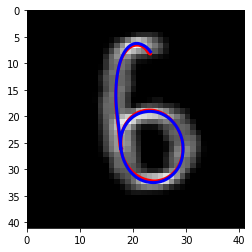

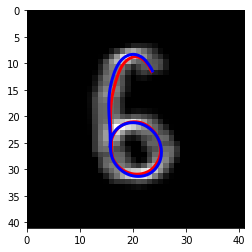

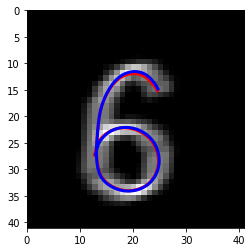

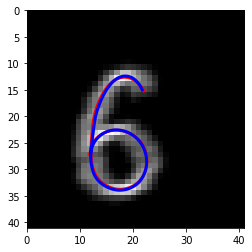

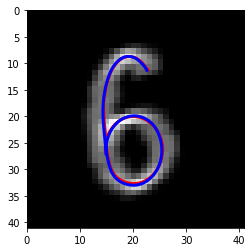

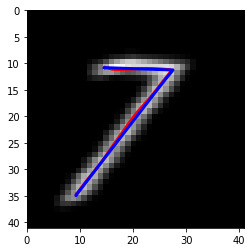

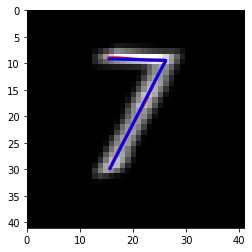

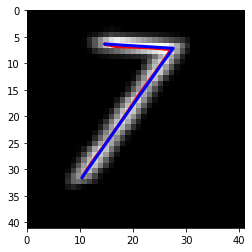

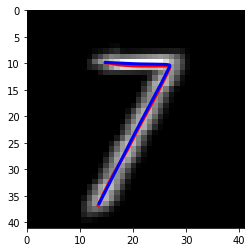

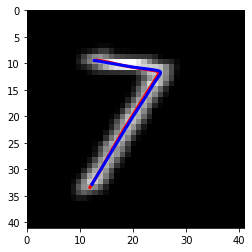

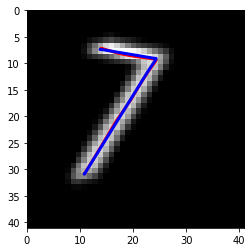

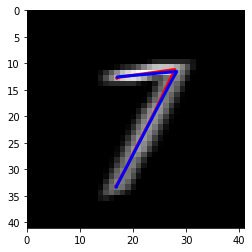

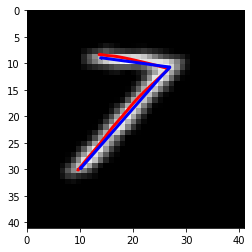

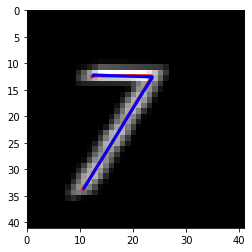

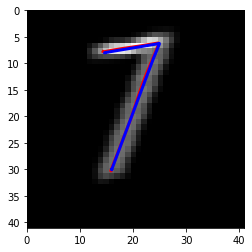

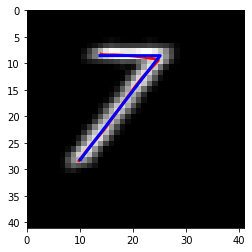

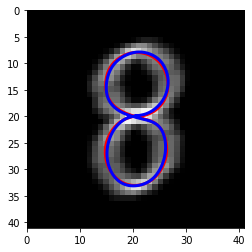

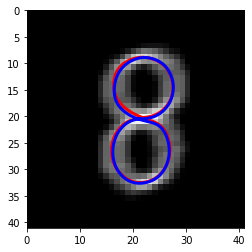

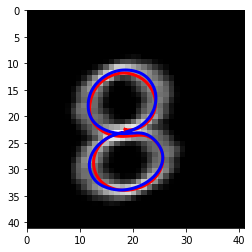

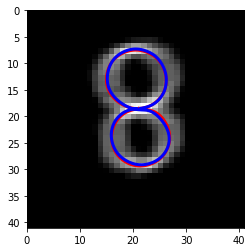

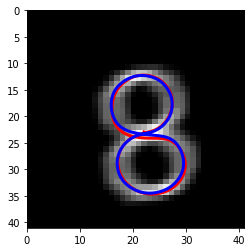

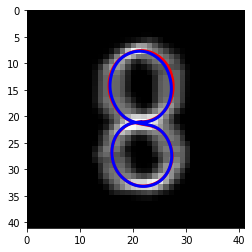

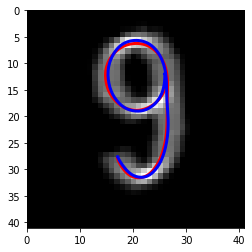

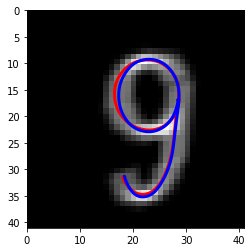

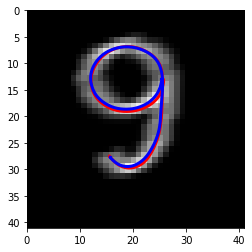

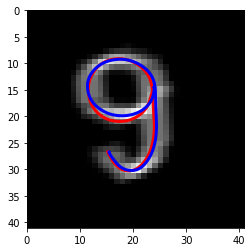

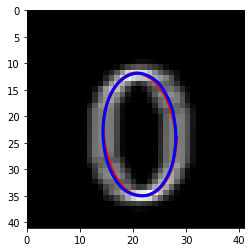

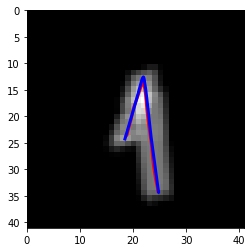

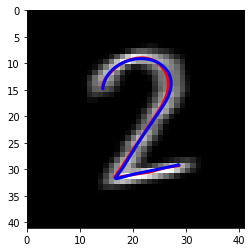

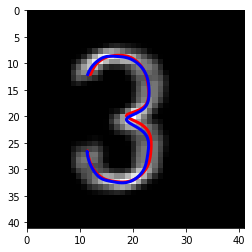

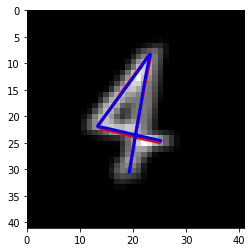

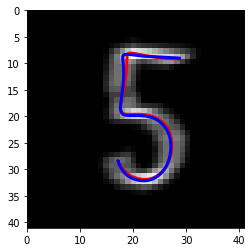

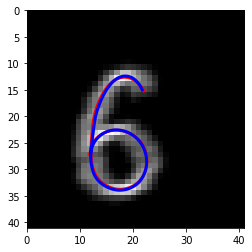

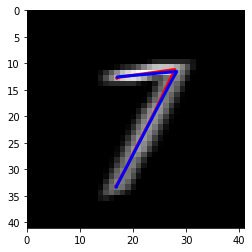

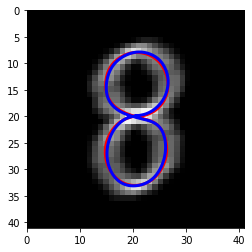

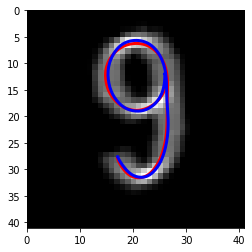

In [20]:
# Examples of Digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# loop for show the images
for i in range(0, len(digit_str)):
    digit = digit_str[i]
    test_sample_indices = test_samples[i]
    show_figures('./images/dnn-dmp/smnist-mb', data_stub, digit,images, outputs, model, test_sample_indices)

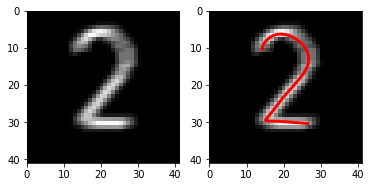

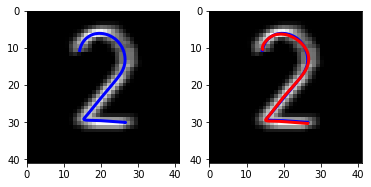

In [21]:
demo()

### 4, DNN-DMP Trained on s-MNIST-RC-AGWN

In [22]:
from imednet.data.smnist_loader import MatLoader, Mapping
from imednet.trainers.encoder_decoder_trainer import Trainer

model_path = os.path.join(root_path, 'models/encoder_decoder/imednet-40x40-smnist-with-reduced-contrast-and-awgn 2021-07-29 22:53:15.083752/')

model = load_model(root_path, model_path)
model_stub = 'imednet_etoe_rc_awgn'
print(model)

EncoderDecoderNet(
  (input_layer): Linear(in_features=1600, out_features=1500, bias=True)
  (middle_layer_1): Linear(in_features=1500, out_features=1300, bias=True)
  (middle_layer_2): Linear(in_features=1300, out_features=1000, bias=True)
  (middle_layer_3): Linear(in_features=1000, out_features=600, bias=True)
  (middle_layer_4): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_5): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_6): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


In [23]:
# Synthetic MNIST with Motion Blur (s-MNIST-RC-AWGN)
data_path = os.path.join(root_path, 'data/s-mnist/40x40-smnist-with-reduced-contrast-and-awgn.mat')
data_stub = 'smnist-rc-awgn'

# Load data and scale it
images, outputs, scale, or_tr = MatLoader.load_data(data_path, load_original_trajectories=True)
trainer = Trainer()

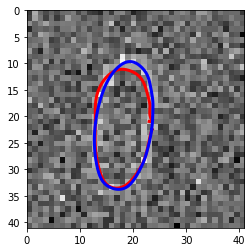

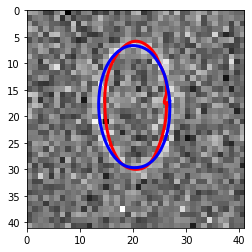

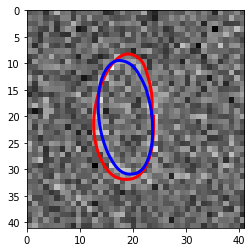

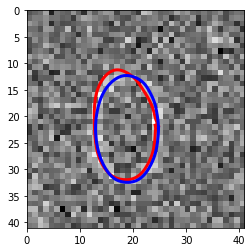

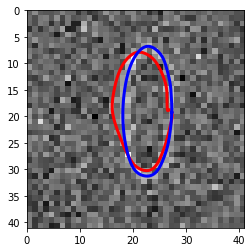

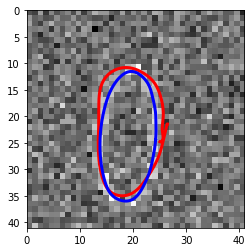

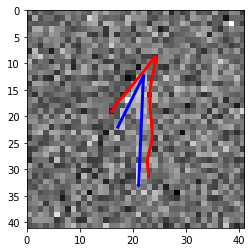

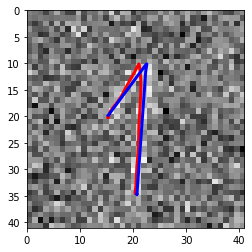

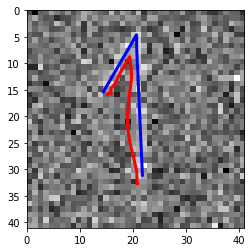

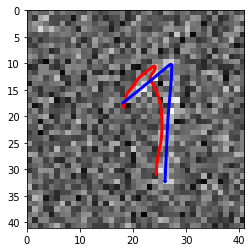

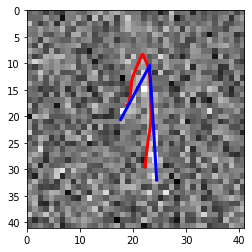

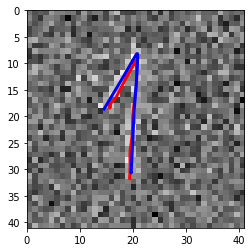

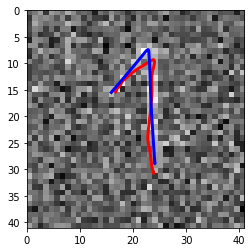

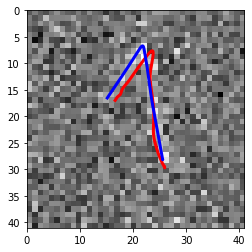

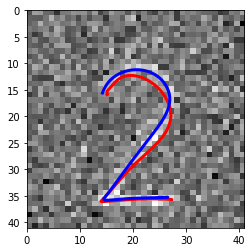

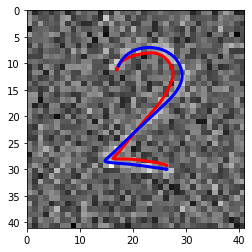

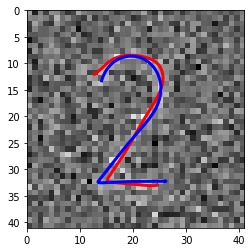

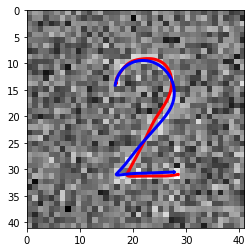

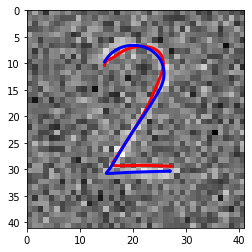

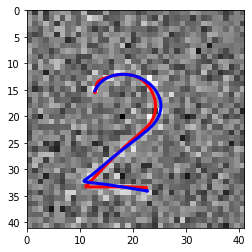

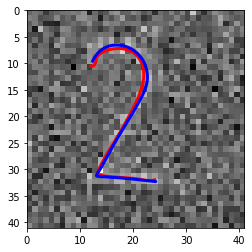

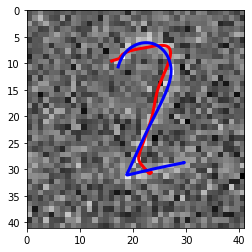

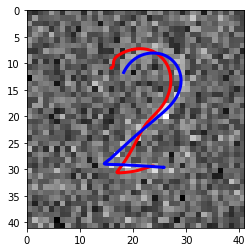

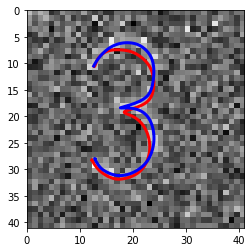

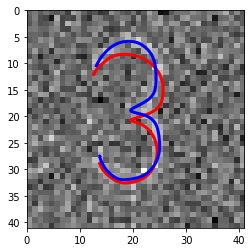

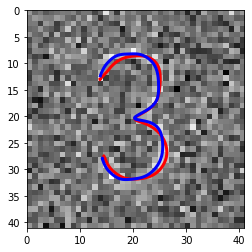

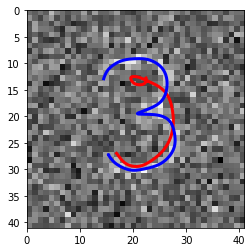

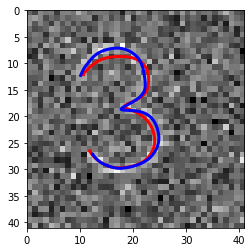

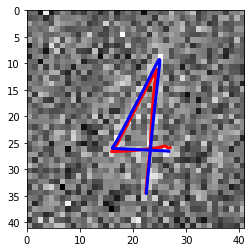

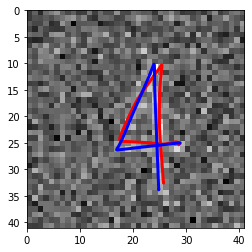

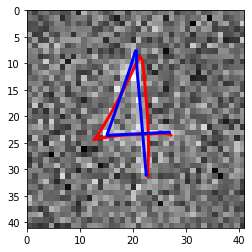

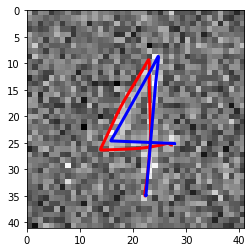

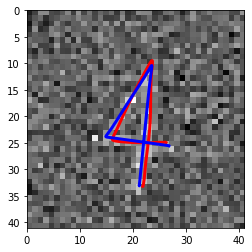

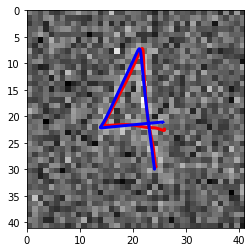

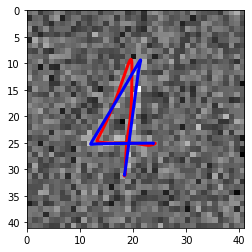

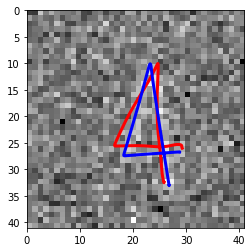

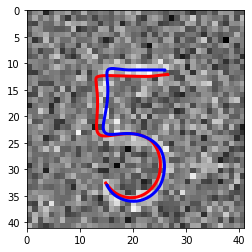

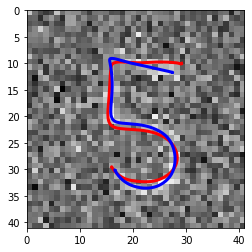

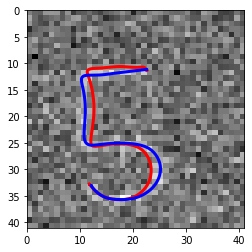

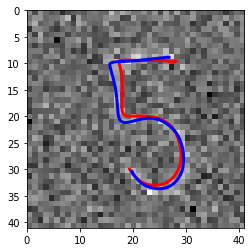

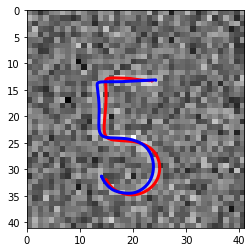

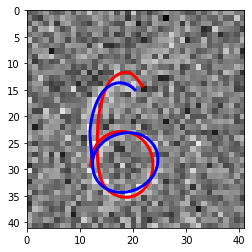

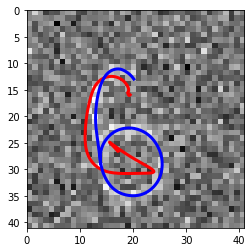

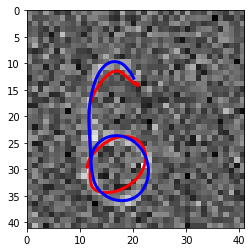

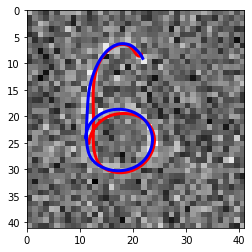

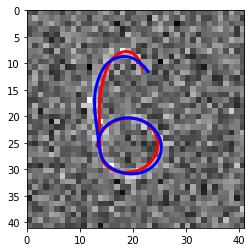

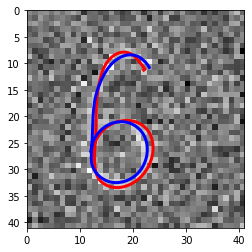

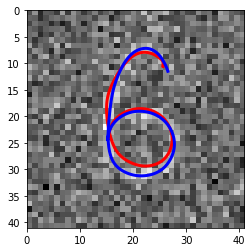

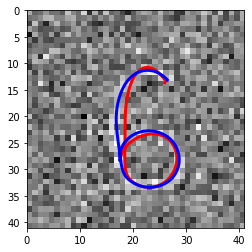

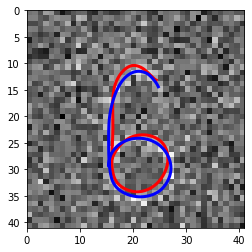

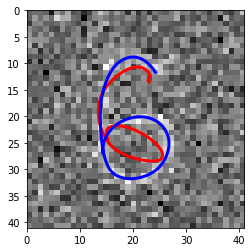

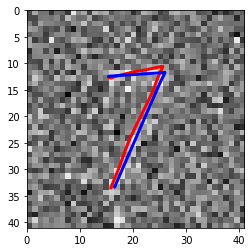

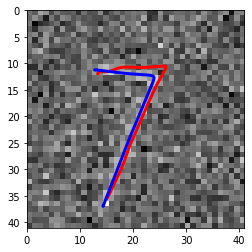

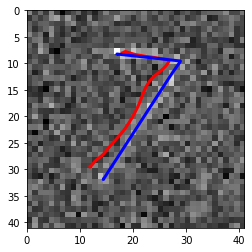

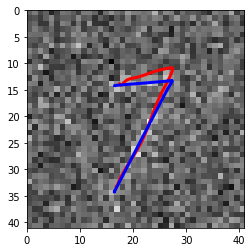

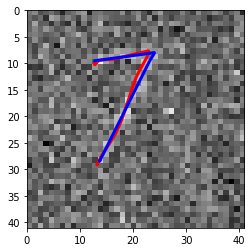

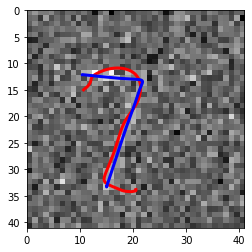

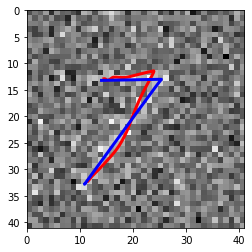

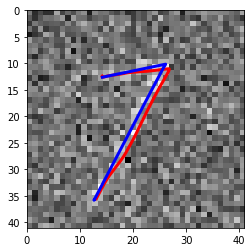

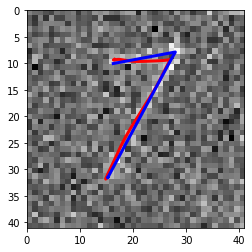

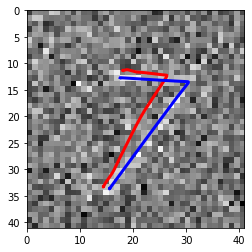

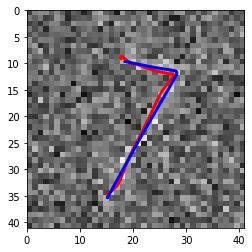

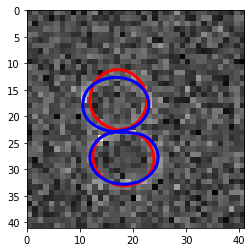

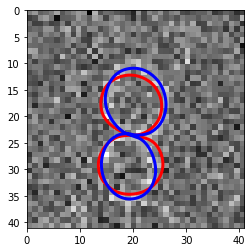

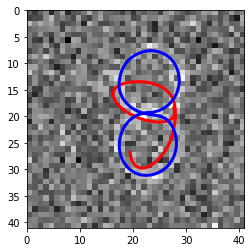

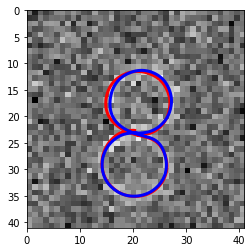

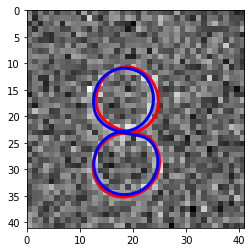

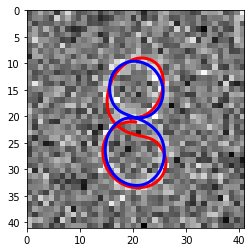

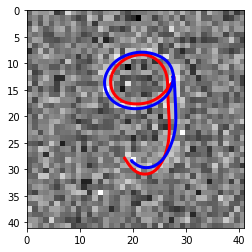

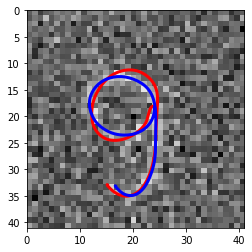

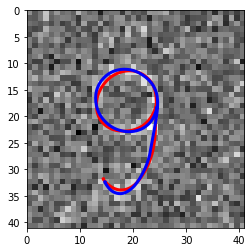

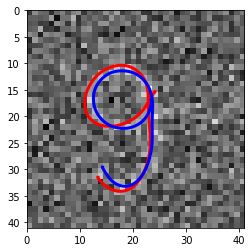

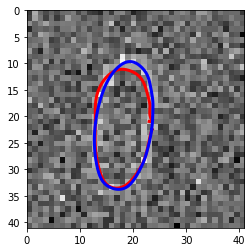

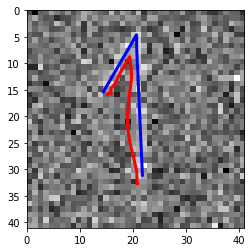

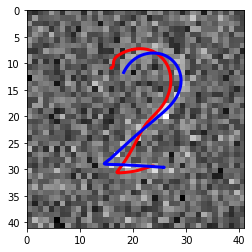

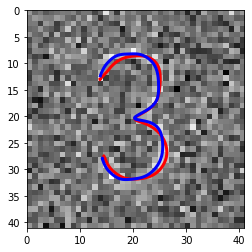

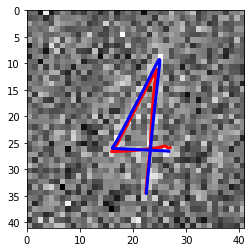

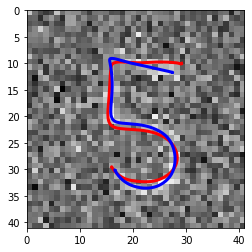

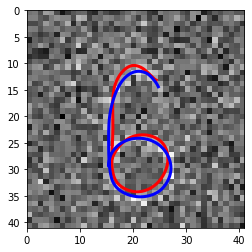

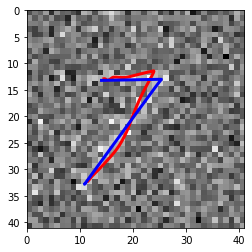

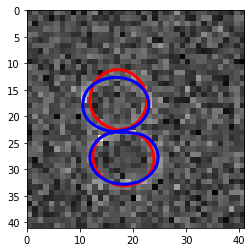

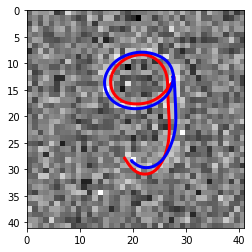

In [24]:
# Examples of Digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# loop for show the images
for i in range(0, len(digit_str)):
    digit = digit_str[i]
    test_sample_indices = test_samples[i]
    show_figures('./images/dnn-dmp/smnist-rc-awgn', data_stub, digit,images, outputs, model, test_sample_indices)

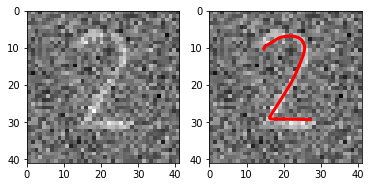

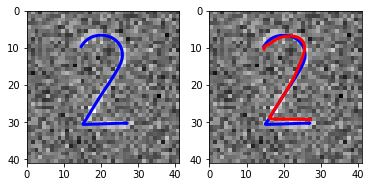

In [25]:
demo()